In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from collections import defaultdict, Counter
import pickle
from pathlib import Path

import seaborn as sns
import torch
from tqdm.auto import tqdm, trange
import transformers

from src.datasets.speech_equivalence import \
    SpeechEquivalenceDataset, SpeechHiddenStateDataset, make_timit_equivalence_dataset
from src.models.integrator import ContrastiveEmbeddingModel, ContrastiveEmbeddingModelConfig, prepare_dataset
from src.utils.timit import load_or_prepare_timit_corpus

In [4]:
model_name = "facebook/wav2vec2-base"

equivalence_classer = "phoneme"
num_frames_per_phoneme = 1

layer = 6
output_dim = 8

equiv_dataset_path = f"data/timit_equiv_{equivalence_classer}_{num_frames_per_phoneme}.pkl"
output_dir = f"out/ce_model_{equivalence_classer}_{layer}_{output_dim}"

## Prepare equivalence class dataset

In [5]:
tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")
feature_extractor = transformers.Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = transformers.Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
model: transformers.Wav2Vec2Model = transformers.Wav2Vec2Model.from_pretrained(model_name)
# model = model.to("cuda")

/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [7]:
dataset = load_or_prepare_timit_corpus("data/timit_phoneme_dev", "data/timit_raw",
                                       processor)

def add_indices(item, idx):
    item["idx"] = idx
    return item
dataset = dataset.map(add_indices, batched=True, batch_size=2000, with_indices=True)

In [8]:
dev_dataset = dataset

In [9]:
equiv_dataset = make_timit_equivalence_dataset(
    f"timit_phoneme/{equivalence_classer}",
    dev_dataset, model,
    equivalence_classer,
    num_frames_per_phoneme=num_frames_per_phoneme)

Extracting hidden states:   0%|          | 0/500 [00:00<?, ? examples/s]

Computing start frames:   0%|          | 0/500 [00:00<?, ? examples/s]

In [10]:
with open(equiv_dataset_path, "wb") as f:
    pickle.dump(equiv_dataset, f)

In [11]:
equiv_dataset

SpeechEquivalenceDataset(timit_phoneme/phoneme, 40 classes, 15824 instances, with SpeechHiddenStateDataset(facebook/wav2vec2-base, 500 items, 75836 frames, 13 layers, 768 hidden size))

In [12]:
# TODO compute how many positive examples each Q lines up. we want to make sure we have a minimal
# number of positive examples for each Q, even the sparse word-level ones

24

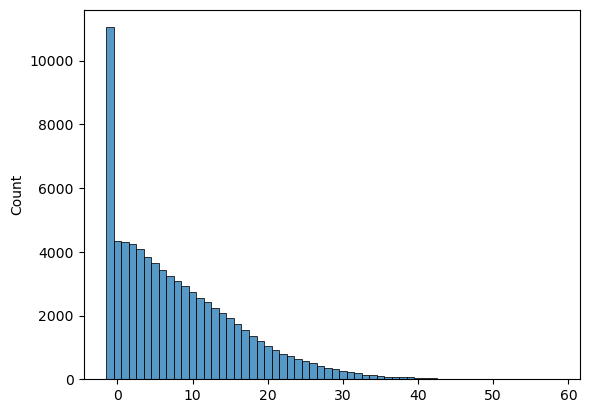

In [13]:
# Pick a max length that accommodates the majority of the samples, excluding outlier lengths
evident_lengths = equiv_dataset.lengths
target_length = int(torch.quantile(evident_lengths.double(), 0.95).item())
sns.histplot(evident_lengths.numpy(), discrete=True)
target_length

In [14]:
ce_dataset = prepare_dataset(equiv_dataset, target_length, layer)

  0%|          | 0/15824 [00:00<?, ?it/s]

In [15]:
Path(output_dir).mkdir(exist_ok=True, parents=True)
ce_dataset.save_to_disk(Path(output_dir) / "dataset")

Saving the dataset (0/8 shards):   0%|          | 0/15824 [00:00<?, ? examples/s]

## Prepare model

In [20]:
ce_model_config = ContrastiveEmbeddingModelConfig(
    base_model_ref=model_name,
    base_model_layer=layer,

    equivalence_classer=equivalence_classer,

    max_length=target_length,
    input_dim=equiv_dataset.hidden_state_dataset.hidden_size,
    hidden_dim=32,
    output_dim=output_dim,
    tau=0.1)


In [21]:
ce_model = ContrastiveEmbeddingModel(ce_model_config)

In [22]:
training_args = transformers.TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    save_steps=100,
    eval_steps=100,
    save_total_limit=5,
    logging_steps=10,
    logging_dir=f"{output_dir}/logs",
    evaluation_strategy="steps",
    logging_first_step=True,
    load_best_model_at_end=True,
    greater_is_better=False,
    remove_unused_columns=False,

    learning_rate=1e-3,
)

dataset_split = ce_dataset.train_test_split(test_size=0.1, shuffle=True)
train_dataset = dataset_split["train"]
eval_dataset = dataset_split["test"]
trainer = transformers.Trainer(
    model=ce_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # compute_metrics=compute_metrics,
    # data_collator=MyCollator(max_length),
    args=training_args)

In [23]:
trainer.train()

  0%|          | 0/892 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': -0.5329, 'learning_rate': 0.0009988789237668162, 'epoch': 0.0}
{'loss': -0.1369, 'learning_rate': 0.0009887892376681615, 'epoch': 0.02}
{'loss': -0.4465, 'learning_rate': 0.000977578475336323, 'epoch': 0.04}
{'loss': -0.2325, 'learning_rate': 0.0009663677130044843, 'epoch': 0.07}
{'loss': 0.0274, 'learning_rate': 0.0009551569506726457, 'epoch': 0.09}
{'loss': -0.2748, 'learning_rate': 0.0009439461883408071, 'epoch': 0.11}
{'loss': -0.0581, 'learning_rate': 0.0009327354260089686, 'epoch': 0.13}
{'loss': 0.2525, 'learning_rate': 0.00092152466367713, 'epoch': 0.16}
{'loss': 0.0092, 'learning_rate': 0.0009103139013452914, 'epoch': 0.18}
{'loss': -0.4201, 'learning_rate': 0.0008991031390134529, 'epoch': 0.2}
{'loss': -0.2796, 'learning_rate': 0.0008878923766816143, 'epoch': 0.22}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': -0.09172569960355759, 'eval_runtime': 35.9407, 'eval_samples_per_second': 44.045, 'eval_steps_per_second': 5.509, 'epoch': 0.22}
{'loss': -0.4683, 'learning_rate': 0.0008766816143497757, 'epoch': 0.25}
{'loss': -0.3264, 'learning_rate': 0.0008654708520179372, 'epoch': 0.27}
{'loss': -0.2088, 'learning_rate': 0.0008542600896860987, 'epoch': 0.29}
{'loss': 0.0392, 'learning_rate': 0.0008430493273542601, 'epoch': 0.31}
{'loss': -0.052, 'learning_rate': 0.0008318385650224215, 'epoch': 0.34}
{'loss': 0.2993, 'learning_rate': 0.000820627802690583, 'epoch': 0.36}
{'loss': -0.1767, 'learning_rate': 0.0008094170403587444, 'epoch': 0.38}
{'loss': 0.2842, 'learning_rate': 0.0007982062780269058, 'epoch': 0.4}
{'loss': 0.2636, 'learning_rate': 0.0007869955156950673, 'epoch': 0.43}
{'loss': -0.1616, 'learning_rate': 0.0007757847533632287, 'epoch': 0.45}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': -0.13413701951503754, 'eval_runtime': 10.0981, 'eval_samples_per_second': 156.763, 'eval_steps_per_second': 19.608, 'epoch': 0.45}
{'loss': -0.2954, 'learning_rate': 0.0007645739910313901, 'epoch': 0.47}
{'loss': -0.243, 'learning_rate': 0.0007533632286995515, 'epoch': 0.49}
{'loss': -0.504, 'learning_rate': 0.000742152466367713, 'epoch': 0.52}
{'loss': -0.5141, 'learning_rate': 0.0007309417040358744, 'epoch': 0.54}
{'loss': 0.0705, 'learning_rate': 0.0007197309417040358, 'epoch': 0.56}
{'loss': -0.4153, 'learning_rate': 0.0007085201793721974, 'epoch': 0.58}
{'loss': 0.016, 'learning_rate': 0.0006973094170403588, 'epoch': 0.61}
{'loss': 0.1473, 'learning_rate': 0.0006860986547085201, 'epoch': 0.63}
{'loss': -0.6788, 'learning_rate': 0.0006748878923766815, 'epoch': 0.65}
{'loss': 0.0197, 'learning_rate': 0.000663677130044843, 'epoch': 0.67}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': -0.0005846740677952766, 'eval_runtime': 9.1069, 'eval_samples_per_second': 173.825, 'eval_steps_per_second': 21.742, 'epoch': 0.67}
{'loss': -0.0793, 'learning_rate': 0.0006524663677130045, 'epoch': 0.7}
{'loss': -0.028, 'learning_rate': 0.0006412556053811658, 'epoch': 0.72}
{'loss': 0.116, 'learning_rate': 0.0006300448430493274, 'epoch': 0.74}
{'loss': 0.5969, 'learning_rate': 0.0006188340807174889, 'epoch': 0.76}
{'loss': -0.7351, 'learning_rate': 0.0006076233183856503, 'epoch': 0.78}
{'loss': 0.0665, 'learning_rate': 0.0005964125560538117, 'epoch': 0.81}
{'loss': -0.1398, 'learning_rate': 0.0005852017937219732, 'epoch': 0.83}
{'loss': -0.351, 'learning_rate': 0.0005739910313901346, 'epoch': 0.85}
{'loss': 0.187, 'learning_rate': 0.000562780269058296, 'epoch': 0.87}
{'loss': -0.1475, 'learning_rate': 0.0005515695067264575, 'epoch': 0.9}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 0.015317185781896114, 'eval_runtime': 9.2262, 'eval_samples_per_second': 171.576, 'eval_steps_per_second': 21.461, 'epoch': 0.9}
{'loss': -0.1523, 'learning_rate': 0.0005403587443946189, 'epoch': 0.92}
{'loss': -0.1746, 'learning_rate': 0.0005291479820627803, 'epoch': 0.94}
{'loss': -0.371, 'learning_rate': 0.0005179372197309418, 'epoch': 0.96}
{'loss': 0.2326, 'learning_rate': 0.0005067264573991032, 'epoch': 0.99}
{'loss': -0.0323, 'learning_rate': 0.0004955156950672646, 'epoch': 1.01}
{'loss': -0.4956, 'learning_rate': 0.000484304932735426, 'epoch': 1.03}
{'loss': -0.2795, 'learning_rate': 0.0004730941704035874, 'epoch': 1.05}
{'loss': -0.0375, 'learning_rate': 0.0004618834080717489, 'epoch': 1.08}
{'loss': 0.0345, 'learning_rate': 0.0004506726457399103, 'epoch': 1.1}
{'loss': -0.1578, 'learning_rate': 0.0004394618834080717, 'epoch': 1.12}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 0.021084178239107132, 'eval_runtime': 8.9778, 'eval_samples_per_second': 176.323, 'eval_steps_per_second': 22.054, 'epoch': 1.12}
{'loss': -0.612, 'learning_rate': 0.00042825112107623323, 'epoch': 1.14}
{'loss': -0.1718, 'learning_rate': 0.00041704035874439463, 'epoch': 1.17}
{'loss': 0.0441, 'learning_rate': 0.0004058295964125561, 'epoch': 1.19}
{'loss': -0.2761, 'learning_rate': 0.0003946188340807175, 'epoch': 1.21}
{'loss': -0.0849, 'learning_rate': 0.00038340807174887893, 'epoch': 1.23}
{'loss': -0.0668, 'learning_rate': 0.0003721973094170404, 'epoch': 1.26}
{'loss': -0.0887, 'learning_rate': 0.0003609865470852018, 'epoch': 1.28}
{'loss': -0.3001, 'learning_rate': 0.00034977578475336324, 'epoch': 1.3}
{'loss': -0.1227, 'learning_rate': 0.00033856502242152463, 'epoch': 1.32}
{'loss': 0.0031, 'learning_rate': 0.0003273542600896861, 'epoch': 1.35}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': -0.024355240166187286, 'eval_runtime': 9.1698, 'eval_samples_per_second': 172.631, 'eval_steps_per_second': 21.593, 'epoch': 1.35}
{'loss': -0.2572, 'learning_rate': 0.00031614349775784754, 'epoch': 1.37}
{'loss': -0.4033, 'learning_rate': 0.000304932735426009, 'epoch': 1.39}
{'loss': -0.3617, 'learning_rate': 0.00029372197309417044, 'epoch': 1.41}
{'loss': 0.2183, 'learning_rate': 0.00028251121076233184, 'epoch': 1.43}
{'loss': -0.0729, 'learning_rate': 0.0002713004484304933, 'epoch': 1.46}
{'loss': -0.1085, 'learning_rate': 0.0002600896860986547, 'epoch': 1.48}
{'loss': -0.0814, 'learning_rate': 0.00024887892376681615, 'epoch': 1.5}
{'loss': -0.2258, 'learning_rate': 0.00023766816143497757, 'epoch': 1.52}
{'loss': -0.533, 'learning_rate': 0.000226457399103139, 'epoch': 1.55}
{'loss': 0.4004, 'learning_rate': 0.00021524663677130048, 'epoch': 1.57}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': -0.039560262113809586, 'eval_runtime': 9.2073, 'eval_samples_per_second': 171.929, 'eval_steps_per_second': 21.505, 'epoch': 1.57}
{'loss': -0.1345, 'learning_rate': 0.0002040358744394619, 'epoch': 1.59}
{'loss': -0.3375, 'learning_rate': 0.00019282511210762333, 'epoch': 1.61}
{'loss': 0.0649, 'learning_rate': 0.00018161434977578475, 'epoch': 1.64}
{'loss': -0.0556, 'learning_rate': 0.00017040358744394618, 'epoch': 1.66}
{'loss': -0.3083, 'learning_rate': 0.0001591928251121076, 'epoch': 1.68}
{'loss': 0.0773, 'learning_rate': 0.00014798206278026908, 'epoch': 1.7}
{'loss': 0.4815, 'learning_rate': 0.0001367713004484305, 'epoch': 1.73}
{'loss': -0.0528, 'learning_rate': 0.00012556053811659193, 'epoch': 1.75}
{'loss': -0.3314, 'learning_rate': 0.00011434977578475336, 'epoch': 1.77}
{'loss': -0.1355, 'learning_rate': 0.00010313901345291481, 'epoch': 1.79}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': -0.021551020443439484, 'eval_runtime': 9.3978, 'eval_samples_per_second': 168.444, 'eval_steps_per_second': 21.069, 'epoch': 1.79}
{'loss': -0.3006, 'learning_rate': 9.192825112107624e-05, 'epoch': 1.82}
{'loss': -0.4205, 'learning_rate': 8.071748878923766e-05, 'epoch': 1.84}
{'loss': -0.0188, 'learning_rate': 6.950672645739911e-05, 'epoch': 1.86}
{'loss': -0.1799, 'learning_rate': 5.829596412556054e-05, 'epoch': 1.88}
{'loss': -0.3733, 'learning_rate': 4.708520179372197e-05, 'epoch': 1.91}
{'loss': -0.0502, 'learning_rate': 3.587443946188341e-05, 'epoch': 1.93}
{'loss': 0.0741, 'learning_rate': 2.4663677130044842e-05, 'epoch': 1.95}
{'loss': -0.5372, 'learning_rate': 1.345291479820628e-05, 'epoch': 1.97}
{'loss': 0.1412, 'learning_rate': 2.242152466367713e-06, 'epoch': 2.0}
{'train_runtime': 676.6009, 'train_samples_per_second': 42.096, 'train_steps_per_second': 1.318, 'train_loss': -0.12709482435153738, 'epoch': 2.0}


TrainOutput(global_step=892, training_loss=-0.12709482435153738, metrics={'train_runtime': 676.6009, 'train_samples_per_second': 42.096, 'train_steps_per_second': 1.318, 'train_loss': -0.12709482435153738, 'epoch': 2.0})